In [1]:
import pandas as pd
import gc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
import lightgbm as lgb
from sklearn.impute import KNNImputer

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
y = train['Y_Class']

for col in train:
    if train[col].nunique() < 2:
        train.drop(columns=col, inplace=True)
        test.drop(columns=col, inplace=True)

num_features = test.select_dtypes(exclude=['object']).columns.to_list()

scaler = StandardScaler()
train[num_features] = scaler.fit_transform(train[num_features])
test[num_features] = scaler.transform(test[num_features])


#from math import *
corr = pd.read_csv('../correlation/correlation.csv')
# Y_Quality 제거
corr = corr.iloc[:-1,:]
important = list(corr[abs(corr['correlation'])>=0.1]['feature'])
#important
train = train[important]
test = test[important]

# 중복된 변수 제거
dup = ~train.T.duplicated()
train = train.loc[:, dup]
test = test.loc[:, dup]



In [3]:
def nan_process(df):
    nans_df = df.isna()
    nans_groups={}
    for col in df.columns:
        cur_group = nans_df[col].sum()
        try:
            nans_groups[cur_group].append(col)
        except:
            nans_groups[cur_group]=[col]
    del nans_df; x=gc.collect()

    pop_list = []
    for k,v in nans_groups.items():
        if len(v) <= 2:
            pop_list.append(k)
    for p in pop_list:
        nans_groups.pop(p)

    keys = list(nans_groups.keys())
    print(len(keys))
    return keys, nans_groups

train_keys, train_nan_groups = nan_process(train)

17


In [7]:
for key in train_keys:
    print(key, len(train_nan_groups[key]))

469 51
478 254
536 45
565 33
480 9
528 5
249 21
498 14
351 84
511 5
575 3
539 6
350 22
556 8
250 25
504 3
349 39


In [5]:
imputer = KNNImputer()
train_clone = train.copy()
num_features = test.select_dtypes(exclude=['object']).columns.to_list()
train_clone[num_features] = imputer.fit_transform(train_clone[num_features])

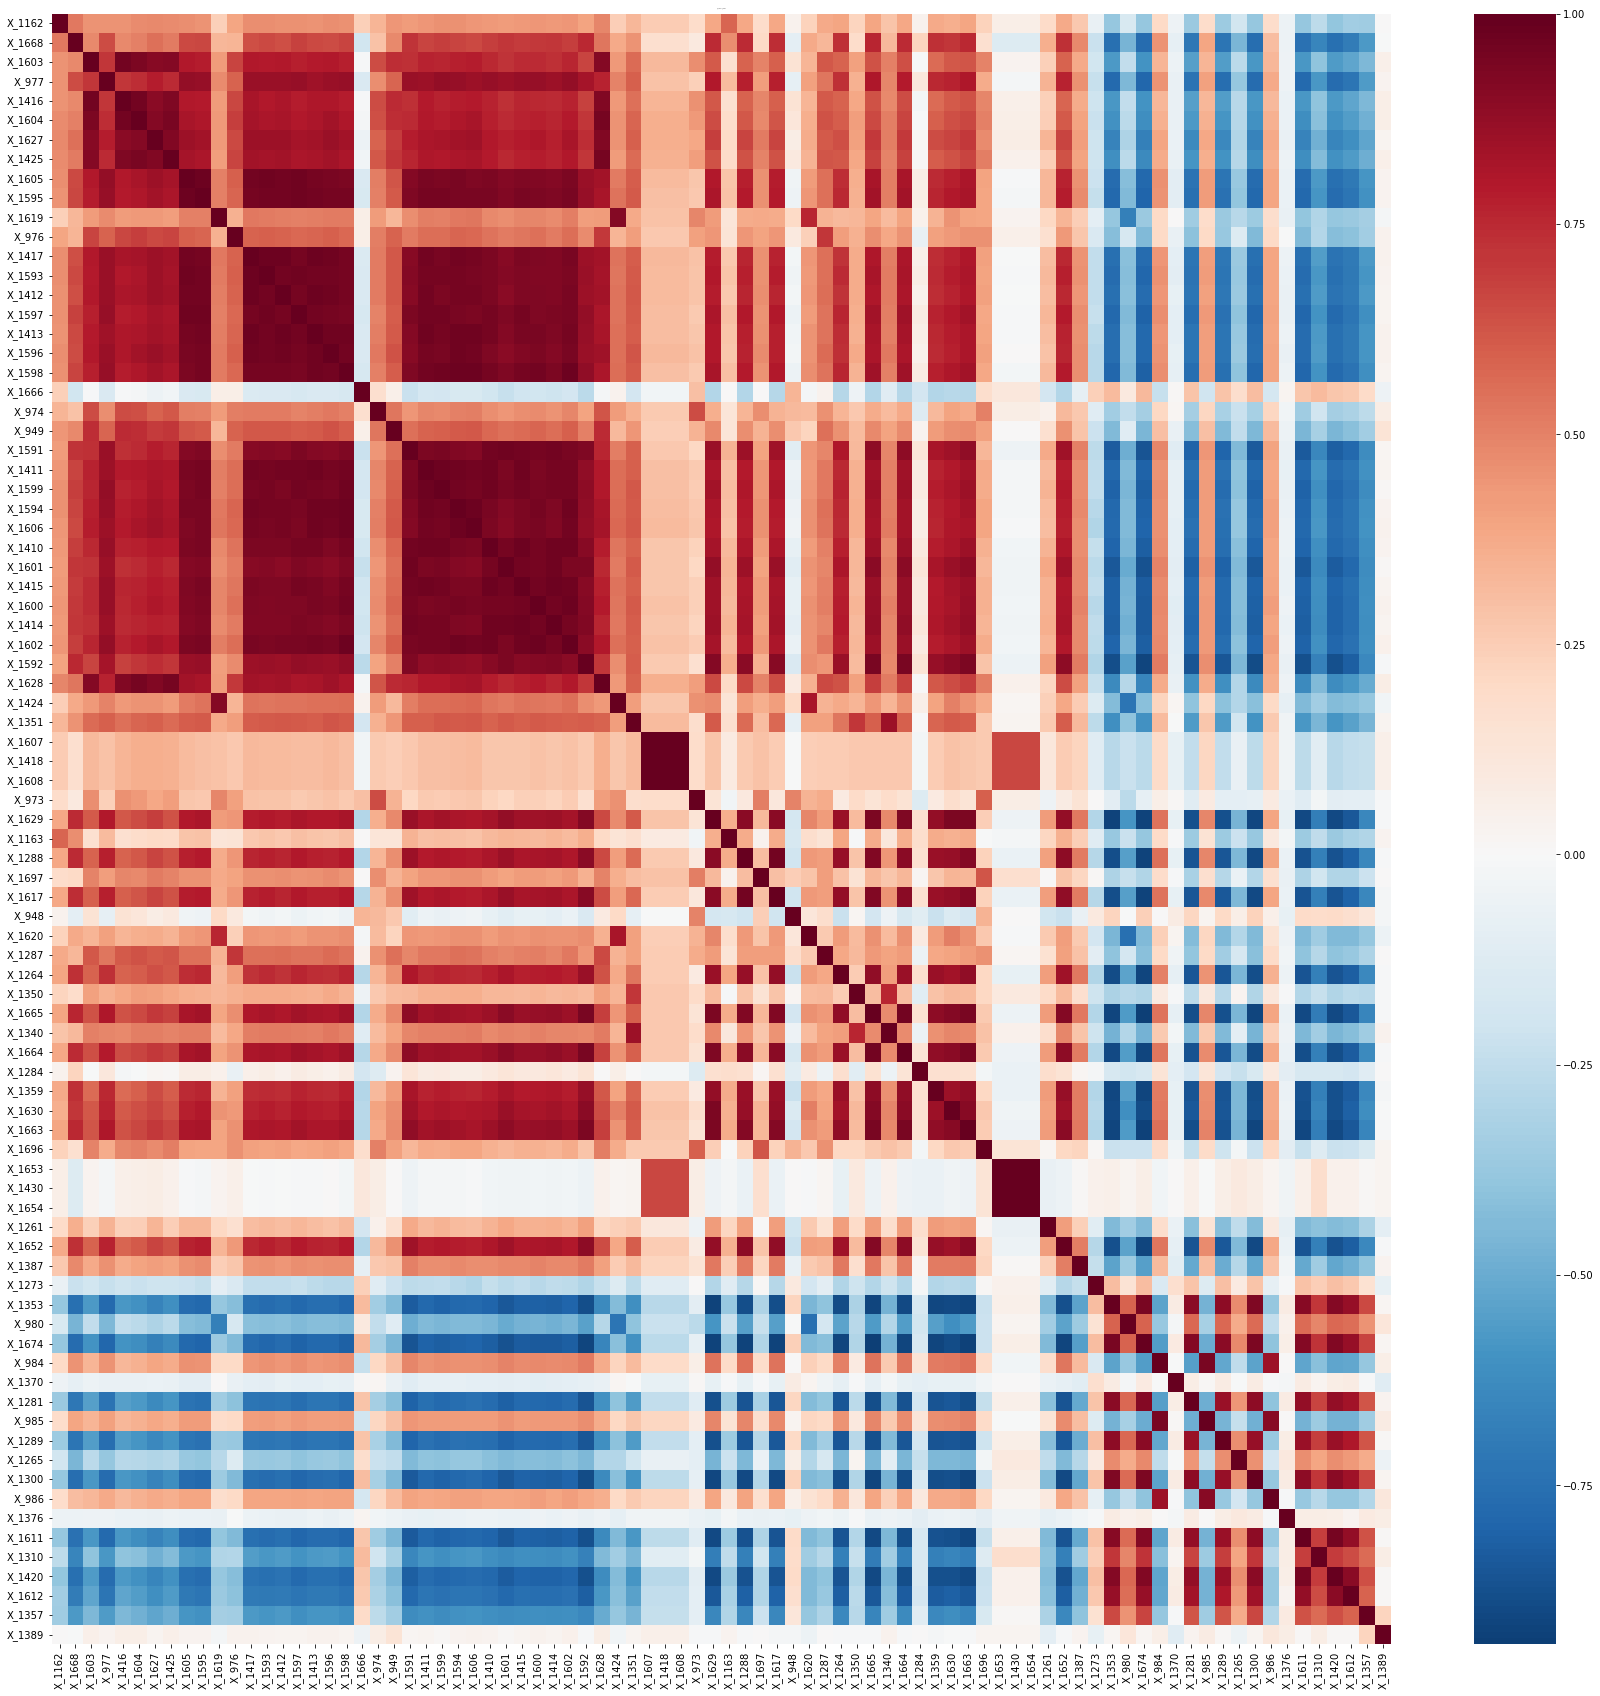

In [16]:
def make_corr(Vs,Vtitle=''):
    cols = Vs
    plt.figure(figsize=(30,30))
    sns.heatmap(train_clone[cols].corr(method= 'kendall'), cmap='RdBu_r', annot=True, center=0.0)
    if Vtitle!='': plt.title(Vtitle,fontsize=1)
    else: plt.title(Vs[0]+' - '+Vs[-1],fontsize=1)
    plt.show()
Vs = train_nan_groups[351]
make_corr(Vs)

### PCA ALGORITHM

In [5]:
# PCA 클래스 설정
class PCA_transform:
  def __init__(self, key):
    self.cols_list = []
    self.pca_list = []
    self.n_pca_list = []
    self.size = 0
    self.key = key
  
  # PCA 클래스의 학습 및 input 값 변환
  def fit_transform(self, X_input, col, n_pca):
    X_pca = X_input[col]
    # n차원으로 차원 축소, target 정보는 제외
    pca = PCA(n_components = n_pca, random_state=25)

    # PCA 학습
    pca.fit(X_pca)

    # PCA transform 후 데이터프레임으로 자료형 변경
    X_pca = pca.transform(X_pca)
    X_pca = pd.DataFrame(X_pca, columns = self.naming(n_pca))
    
    X_input = pd.concat([X_input, X_pca], axis = 1)
    X_input = X_input.drop(col, axis = 1)

    self.cols_list.append(col)
    self.pca_list.append(pca)
    self.n_pca_list.append(n_pca)
    self.size += 1

    return X_input

  # 학습된 PCA 값으로 transform
  def transform(self, X_input):
    for idx in range(self.size):
      X_input = self._idx_transform(X_input, idx)
    
    return X_input

  # n번째 PCA 변환
  def _idx_transform(self, X_input, idx):
    X_pca = X_input[self.cols_list[idx]]

    # pca transform 후 데이터프레임으로 자료형 변경
    X_pca = self.pca_list[idx].transform(X_pca)
    X_pca = pd.DataFrame(X_pca, columns = self.naming(self.n_pca_list[idx], idx))

    X_input = pd.concat([X_input, X_pca], axis = 1)
    X_input = X_input.drop(self.cols_list[idx], axis = 1)

    return X_input

  # PCA 된 컬럼 이름 규칙
  def naming(self, number, name = None):
    if (name is None):
      name = self.size
    names = []
    for idx in range(number):
      names.append(f'PCA_key{self.key}_{str(name)}_{idx}')
    return names


In [ ]:
imputer = KNNImputer()
train_clone = train.copy()
num_features = test.select_dtypes(exclude=['object']).columns.to_list()
train_clone[num_features] = imputer.fit_transform(train_clone[num_features])

In [ ]:
#imputer = KNNImputer()
#train_clone = train.copy()
#num_features = test.select_dtypes(exclude=['object']).columns.to_list()
#train_clone[num_features] = imputer.fit_transform(train_clone[num_features])
#dup_groups = []
#for key in train_keys:
#    for groups in train_nan_groups[key]:
#        cor = train_clone[groups].corr()
#        for element in groups:
#            dup = []

        
    


In [6]:
optimized_pca_param = {}

imputer = KNNImputer()
train_clone = train.copy()
num_features = test.select_dtypes(exclude=['object']).columns.to_list()
train_clone[num_features] = imputer.fit_transform(train_clone[num_features])

for key in train_nan_groups.keys():
    if key == 0 or key < 500:
        continue
    group = train_nan_groups[key]
    for i in range(1, len(group)+1):
        pca = PCA(i)
        tmp = train_clone[group]
        pca.fit(tmp)
        if sum(pca.explained_variance_ratio_) > 0.9999:
            print(f"{key} Over 95% idx : {i}")
            optimized_pca_param[key] = i
            break
    
        

536 Over 95% idx : 18
565 Over 95% idx : 16
528 Over 95% idx : 5
511 Over 95% idx : 5
575 Over 95% idx : 2
539 Over 95% idx : 6
556 Over 95% idx : 6
504 Over 95% idx : 3


In [ ]:
imputer = KNNImputer()

train_clone = train.copy()
test_clone = test.copy()

num_features = test.select_dtypes(exclude=['object']).columns.to_list()
train_clone[num_features] = imputer.fit_transform(train_clone[num_features])
test_clone[num_features] = imputer.transform(test_clone[num_features])

In [ ]:
#for key in train_keys[2:]:
key = 351
pca_5 = PCA_transform(key)
group = train_nan_groups[key]
train_clone = pca_5.fit_transform(train_clone, group, optimized_pca_param[key])
test_clone = pca_5.transform(test_clone)

In [7]:
import random
import os
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(25) 
SEED = 25

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
#params = study.best_params
params = {'num_leaves': 17,
    'max_depth': 11,
    'learning_rate': 0.07028290319049474,
    'n_estimators': 78,
    'class_weight': 'balanced',
    'min_child_samples': 12,
    'subsample': 0.831632859850219,
    'colsample_bytree': 0.9362544923583181,
    'reg_alpha': 0.01941513921336218,
    'reg_lambda': 0.0021722692515700652}
N = len(optimized_pca_param.keys())

# -- Define the objective function
def objective(trial):
    imputer = KNNImputer()
    train_clone = train.copy()
    num_features = test.select_dtypes(exclude=['object']).columns.to_list()
    train_clone[num_features] = imputer.fit_transform(train_clone[num_features])
    for k in list(optimized_pca_param.keys()):
        pca_n_components=trial.suggest_int(f"{k}_pca_n_components", 2, optimized_pca_param[k]) # suggest an integer from 2 to 30
        pca_5 = PCA_transform(k)
        group = train_nan_groups[k]
        train_clone = pca_5.fit_transform(train_clone, group, pca_n_components)
   
    kf = KFold(n_splits=10, shuffle=True, random_state=25)

    clfs = []
    scores = []
    for train_index, test_index in kf.split(train_clone, y):
        #print(train_index)
        X_train, X_valid = train_clone.values[train_index], train_clone.values[test_index]
        y_train, y_valid = y.values[train_index], y.values[test_index]
        model = LGBMClassifier(random_state=25, verbose=-1, **params)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
        pred = model.predict(X_valid)
        f1 = f1_score(y_valid, pred, average='macro')
        scores.append(f1)
        clfs.append(model)

    # -- Evaluate the score by cross-validation
    f1 = np.mean(scores)
    return f1

study = optuna.create_study(direction="maximize") # maximise the score during tuning
study.optimize(objective, n_trials=1000) # run the objective function 100 times

print(study.best_trial) # print the best performing pipeline

In [9]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
#params = study.best_params
params = {'num_leaves': 17,
    'max_depth': 11,
    'learning_rate': 0.07028290319049474,
    'n_estimators': 78,
    'class_weight': 'balanced',
    'min_child_samples': 12,
    'subsample': 0.831632859850219,
    'colsample_bytree': 0.9362544923583181,
    'reg_alpha': 0.01941513921336218,
    'reg_lambda': 0.0021722692515700652}
N = len(optimized_pca_param.keys())

# -- Define the objective function
def objective(trial):
    imputer = KNNImputer()
    train_clone = train.copy()
    num_features = test.select_dtypes(exclude=['object']).columns.to_list()
    train_clone[num_features] = imputer.fit_transform(train_clone[num_features])
    kf = KFold(n_splits=10, shuffle=True, random_state=25)
    param_d = {}
    for k in list(optimized_pca_param.keys()):
        pca_n_components=trial.suggest_int(f"{k}_pca_n_components", 2, optimized_pca_param[k]) #
        param_d[k] = (pca_n_components)
        
    clfs = []
    scores = []
    for train_index, test_index in kf.split(train_clone, y):
        #print(train_index)
        X = train_clone.copy()
        X_train, X_valid = X.iloc[train_index].reset_index(), X.iloc[test_index].reset_index()
        y_train, y_valid = y.values[train_index], y.values[test_index]
        pca_5 = PCA_transform(k)
        for k in list(optimized_pca_param.keys()):
            group = train_nan_groups[k]
            X_train = pca_5.fit_transform(X_train, group, param_d[k])
            
        X_valid = pca_5.transform(X_valid)
        model = LGBMClassifier(random_state=25, verbose=-1, **params)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
        pred = model.predict(X_valid)
        f1 = f1_score(y_valid, pred, average='macro')
        scores.append(f1)
        clfs.append(model)

    # -- Evaluate the score by cross-validation
    f1 = np.mean(scores)
    return f1

study = optuna.create_study(direction="maximize") # maximise the score during tuning
study.optimize(objective, n_trials=10000) # run the objective function 100 times

print(study.best_trial) # print the best performing pipeline

[I 2023-02-19 16:32:49,005] A new study created in memory with name: no-name-cc66f1ef-c8ef-4fd6-8af0-475b24013881
[I 2023-02-19 16:32:55,276] Trial 0 finished with value: 0.672743266854893 and parameters: {'536_pca_n_components': 8, '565_pca_n_components': 6, '528_pca_n_components': 5, '511_pca_n_components': 4, '575_pca_n_components': 2, '539_pca_n_components': 2, '556_pca_n_components': 2, '504_pca_n_components': 3}. Best is trial 0 with value: 0.672743266854893.
[I 2023-02-19 16:33:01,704] Trial 1 finished with value: 0.670014453852082 and parameters: {'536_pca_n_components': 6, '565_pca_n_components': 8, '528_pca_n_components': 5, '511_pca_n_components': 4, '575_pca_n_components': 2, '539_pca_n_components': 2, '556_pca_n_components': 6, '504_pca_n_components': 2}. Best is trial 0 with value: 0.672743266854893.
[I 2023-02-19 16:33:08,157] Trial 2 finished with value: 0.69101631982341 and parameters: {'536_pca_n_components': 3, '565_pca_n_components': 15, '528_pca_n_components': 3, '

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier

imputer = KNNImputer()
train_clone = train.copy()
test_clone = test.copy()
num_features = test.select_dtypes(exclude=['object']).columns.to_list()
train_clone[num_features] = imputer.fit_transform(train_clone[num_features])
test_clone[num_features] = imputer.transform(test_clone[num_features])
for k in list(optimized_pca_param.keys())[2:]:
        name = f"{k}_pca_n_components"
        pca_n_components = study.best_params[name]
        pca_5 = PCA_transform(k)
        group = train_nan_groups[k]
        train_clone = pca_5.fit_transform(train_clone, group, pca_n_components)
        test_clone = pca_5.transform(test_clone)
    
kf = KFold(n_splits=10, shuffle=True, random_state=25)

clfs = []
scores = []
for train_index, test_index in kf.split(train_clone, y):
    #print(train_index)
    X_train, X_valid = train_clone.values[train_index], train_clone.values[test_index]
    y_train, y_valid = y.values[train_index], y.values[test_index]
    
    #params = study.best_params
    params = {'num_leaves': 17,
        'max_depth': 11,
        'learning_rate': 0.07028290319049474,
        'n_estimators': 78,
        'class_weight': 'balanced',
        'min_child_samples': 12,
        'subsample': 0.831632859850219,
        'colsample_bytree': 0.9362544923583181,
        'reg_alpha': 0.01941513921336218,
        'reg_lambda': 0.0021722692515700652}
            
    model = LGBMClassifier(random_state=25, verbose=-1, **params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    pred = model.predict(X_valid)
    f1 = f1_score(y_valid, pred, average='macro')
    scores.append(f1)
    clfs.append(model)
print('Mean F1:', np.mean(scores))
#0.682161892591053

In [ ]:
preds = []
for i, model in enumerate(clfs):
    pred = model.predict_proba(test_clone)
    if i == 0:
        preds = pred
    else:
        preds += pred
print(preds)
final_pred = np.argmax(preds, axis=1)

submit = pd.read_csv('../sample_submission.csv')
submit['Y_Class'] = final_pred
submit.to_csv('../submission_PCA.csv', index=False)
final_pred

In [ ]:
#train_add = ["PRODUCT_ID", "Y_Class", "Y_Quality", "TIMESTAMP", "LINE", "PRODUCT_CODE"]
#test_add = ["PRODUCT_ID","TIMESTAMP", "LINE", "PRODUCT_CODE"]

#save_train = pd.concat([train[train_add], train_clone], axis=1)
#save_test = pd.concat([test[test_add], test_clone], axis=1)

#save_train.to_csv("train_PCA.csv", index=False)
#save_test.to_csv("test_PCA.csv", index=False)

### IEEE FRUAD ALGORITHM

In [ ]:
def reduce_group(grps):
    use = []
    for g in grps:
        mx = 0; vx = g[0]
        for gg in g:
            n = train[str(gg)].nunique()
            if n > mx:
                mx = n
                vx = gg
            #print(str(gg)+'-'+str(n),', ',end='')
        use.append(vx)
        #print()
    return list(set(use))

use_columns = []
for idx in range(1, len(train_keys)):
    correlated = []
    Vs = train_nan_groups[train_keys[idx]]
    is_visited = [False] * len(Vs)
    corr = train[Vs].corr()
    for i in range(len(Vs)):
        tmp = []
        if is_visited[i] == False:
            is_visited[i] = True
            tmp.append(Vs[i])
            for j in range(i+1, len(Vs)):
                ratio = abs(corr.iloc[i, j])
                if ratio >= .95:
                    is_visited[j]=True
                    tmp.append(Vs[j])
            correlated.append(tmp)
        else:
            pass
    new_correlated = []
    for v in Vs:
        tmp = None
        for cor in correlated:
            if v in cor:
                if tmp is None:
                    tmp = cor
                else:
                    tmp.extend(cor)

        new_correlated.append(tmp)
    #print(correlated)
    #print(new_correlated)
    #for cor in correlated:
    #    if len(cor) > 1:
    #        pca_5 = PCA_transform()
    #        train = pca_5.fit_transform(train, cor, 1)
    #        test = pca_5.transform(test)
    final = reduce_group(correlated)
    final.sort(key=lambda x : int(x.split('_')[1]))
    #print("Final", final)
    use_columns.extend(final)
    #make_corr(Vs, train_keys[idx])


In [ ]:
train_save_columns = ["PRODUCT_ID", "Y_Class", "Y_Quality", "TIMESTAMP", "LINE", "PRODUCT_CODE"] + use_columns
test_save_columns = ["PRODUCT_ID","TIMESTAMP", "LINE", "PRODUCT_CODE"] + use_columns

In [ ]:
len(train_save_columns)

In [ ]:
train = train_clone[train_save_columns]
test = test_clone[test_save_columns]

### 249 NAN

In [ ]:
#train = train[train_save_columns]
#test = test[test_save_columns]

train.to_csv("train_reduce.csv", index=False)
test.to_csv("test_reduce.csv", index=False)


In [ ]:

#train[]

In [ ]:
#Create train and validation set
train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1302)

In [ ]:
# lightgbm을 구현하여 shap value를 예측할 것
# ligthgbm 구현

# library
import lightgbm as lgb  # 없을 경우 cmd/anaconda prompt에서 install
from math import sqrt
from sklearn.metrics import mean_squared_error

# lightgbm model
lgb_dtrain = lgb.Dataset(data = train_x, label = train_y) # LightGBM 모델에 맞게 변환
lgb_param = {'max_depth': 10,
            'learning_rate': 0.01, # Step Size
            'n_estimators': 1000, # Number of trees
            'objective': 'regression'} # 목적 함수 (L2 Loss)
lgb_model = lgb.train(params = lgb_param, train_set = lgb_dtrain) # 학습 진행
lgb_model_predict = lgb_model.predict(valid_x) # test data 예측
print("RMSE: {}".format(sqrt(mean_squared_error(lgb_model_predict, valid_y)))) # RMSE

In [ ]:
# shap value 
import shap
explainer = shap.TreeExplainer(lgb_model) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(valid_x) # Shap Values 계산

In [ ]:
shap.initjs() # javascript 초기화 (graph 초기화)
shap.summary_plot(shap_values, valid_x, plot_type = "bar")

In [ ]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(train_x.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.to_csv("SHAP_values.csv", index=False)

In [ ]:
X.drop(columns=list(feature_importance[feature_importance['feature_importance_vals'] == 0]['col_name']), inplace=True)

In [ ]:
import pandas as pd
feature_importance = pd.read_csv("SHAP_values.csv")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
#train =train[["Y_Quality", "Y_Class", "PRODUCT_CODE", "LINE"] + list(feature_importance[feature_importance['feature_importance_vals'] == 0]['col_name'])]
#train.to_csv("tmp.csv", index=False)
#test = test[["PRODUCT_CODE", 'LINE'] + list(feature_importance[feature_importance['feature_importance_vals'] == 0]['col_name'])]
#test.to_csv("tmp_test.csv", index=False)

## 다중 공산성 처리

In [ ]:
import statsmodels.api as sm

train = pd.read_csv("train_mice.csv")
test = pd.read_csv('test_mice.csv')

for col in train:
    if train[col].nunique() < 2:
        train.drop(columns=col, inplace=True)
        test.drop(columns=col, inplace=True)

# 중복된 변수 제거
dup = ~train.T.duplicated()
train = train.loc[:, dup]
test = test.loc[:, dup]

y = train[["Y_Quality"]]
X = train.drop(columns=["PRODUCT_ID","Y_Class", "Y_Quality", "TIMESTAMP"])
test_X = test.drop(columns=["PRODUCT_ID", "TIMESTAMP"])

num_features = X.select_dtypes(exclude=['object']).columns.to_list()

scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])
test_X[num_features] = scaler.transform(test_X[num_features])

# qualitative to quantitative
qual_col = ['PRODUCT_CODE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(X[i])
    X[i] = le.transform(X[i])
    
    for label in np.unique(test_X[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_X[i] = le.transform(test_X[i]) 
    

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
LINE = ["T010305", "T010306", "T050304", "T050307", "T100304", "T100306"]
line_x = X[X["LINE"] == LINE[0]].drop(columns=["LINE"]).dropna(axis=1, how="all")
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(line_x.values, i) for i in range(line_x.shape[1])]
vif['features'] = line_x.columns

vif0 = vif.sort_values("VIF Factor").reset_index(drop=True)
vif0

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
LINE = ["T010305", "T010306", "T050304", "T050307", "T100304", "T100306"]
line_x = X[X["LINE"] == LINE[1]].drop(columns=["LINE"]).dropna(axis=1, how="all")
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(line_x.values, i) for i in range(line_x.shape[1])]
vif['features'] = line_x.columns

vif1 = vif.sort_values("VIF Factor").reset_index(drop=True)
vif1

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
LINE = ["T010305", "T010306", "T050304", "T050307", "T100304", "T100306"]
line_x = X[X["LINE"] == LINE[2]].drop(columns=["LINE"]).dropna(axis=1, how="all")
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(line_x.values, i) for i in range(line_x.shape[1])]
vif['features'] = line_x.columns

vif2 = vif.sort_values("VIF Factor").reset_index(drop=True)
vif2

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
LINE = ["T010305", "T010306", "T050304", "T050307", "T100304", "T100306"]
line_x = X[X["LINE"] == LINE[3]].drop(columns=["LINE"]).dropna(axis=1, how="all")
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(line_x.values, i) for i in range(line_x.shape[1])]
vif['features'] = line_x.columns

vif3 = vif.sort_values("VIF Factor").reset_index(drop=True)
vif3

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
LINE = ["T010305", "T010306", "T050304", "T050307", "T100304", "T100306"]
line_x = X[X["LINE"] == LINE[4]].drop(columns=["LINE"]).dropna(axis=1, how="all")
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(line_x.values, i) for i in range(line_x.shape[1])]
vif['features'] = line_x.columns

vif4 = vif.sort_values("VIF Factor").reset_index(drop=True)
vif4

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
LINE = ["T010305", "T010306", "T050304", "T050307", "T100304", "T100306"]
line_x = X[X["LINE"] == LINE[5]].drop(columns=["LINE"]).dropna(axis=1, how="all")
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(line_x.values, i) for i in range(line_x.shape[1])]
vif['features'] = line_x.columns

vif5 = vif.sort_values("VIF Factor").reset_index(drop=True)
vif5

In [ ]:
json_output = {}
json_output[LINE[0]] = vif0[vif0['VIF Factor'] > 10]['features'].to_list()
json_output[LINE[1]] = vif1[vif1['VIF Factor'] > 10]['features'].to_list()
json_output[LINE[2]] = vif2[vif2['VIF Factor'] > 10]['features'].to_list()
json_output[LINE[3]] = vif3[vif3['VIF Factor'] > 10]['features'].to_list()
json_output[LINE[4]] = vif4[vif4['VIF Factor'] > 10]['features'].to_list()
json_output[LINE[5]] = vif5[vif5['VIF Factor'] > 10]['features'].to_list()

import json
with open("VIF.json", 'w') as fp:
    json.dump(json_output, fp)